# Person of Interest (POI) Classifier for Enron Data

Qingyu Li

## 1. Project Overview

In 2000, Enron was one of the largest companies in the United States. By 2002, it had collapsed into bankruptcy due to widespread corporate fraud. In the resulting Federal investigation, there was a significant amount of typically confidential information entered into public record, including tens of thousands of emails and detailed financial data for top executives. In this project, we will find features that provide useful information and build a person of interest identifier. We will test the accuracy of prediction of our classifier and find the best predicting model.

## 2. Data Preparation

In [1]:
import sys
import pickle
import numpy
import pandas as pd
import matplotlib

from ggplot import *

sys.path.append("../tools/")

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from feature_format import featureFormat, targetFeatureSplit

target_label = 'poi'
email_features_list = [
    # 'email_address', # remit email address; informational label
    'from_messages',
    'from_poi_to_this_person',
    'from_this_person_to_poi',
    'shared_receipt_with_poi',
    'to_messages',
    ]
financial_features_list = [
    'bonus',
    'deferral_payments',
    'deferred_income',
    'director_fees',
    'exercised_stock_options',
    'expenses',
    'loan_advances',
    'long_term_incentive',
    'other',
    'restricted_stock',
    'restricted_stock_deferred',
    'salary',
    'total_payments',
    'total_stock_value',
]
features_list = [target_label] + financial_features_list + email_features_list

In [2]:
### Load the dictionary containing the dataset
data_dict = pickle.load(open("final_project_dataset.pkl", "r") )
## Load POI names file
poi = open("poi_names.txt", "r")

How many people are in the dataset?

In [5]:
len(data_dict.keys())

146

How many features are in the dataset?

In [6]:
len(data_dict.values()[0])

21

From the above, we can see that there are 146 people in this dataset and 21 features in total. Next we print out an example of the data point for better understanding.

In [7]:
data_dict[data_dict.keys()[0]]

{'bonus': 600000,
 'deferral_payments': 'NaN',
 'deferred_income': 'NaN',
 'director_fees': 'NaN',
 'email_address': 'mark.metts@enron.com',
 'exercised_stock_options': 'NaN',
 'expenses': 94299,
 'from_messages': 29,
 'from_poi_to_this_person': 38,
 'from_this_person_to_poi': 1,
 'loan_advances': 'NaN',
 'long_term_incentive': 'NaN',
 'other': 1740,
 'poi': False,
 'restricted_stock': 585062,
 'restricted_stock_deferred': 'NaN',
 'salary': 365788,
 'shared_receipt_with_poi': 702,
 'to_messages': 807,
 'total_payments': 1061827,
 'total_stock_value': 585062}

Convert data into data frame:

In [3]:
# remove outlier key-value pair (errant total)
data_dict.pop('TOTAL',0)
data_dict.pop('LOCKHART EUGENE E', 0)
# reload data after cleaning data outlier using pop to remove TOTAL line
df=pd.DataFrame.from_records(list(data_dict.values()))

First by eyebowing the data, I decided to remove the total row and one row with person name "Lockhart Eugene E" that has all the missing values. 

In [4]:
df.shape

(144, 21)

After removing the total line and the person with all NaN values, there are 144 key executives in the dataset with 21 features.

In [5]:
len(df[df['poi']==1])

18

There are 18 person of interest labeled in the dataset. 

### 2.1 Missing Values

We can see that the missing value are coded as 'NaN'. Next we will need to deal with the 'NaN' and outliers.

In [9]:
df.head()

bonus deferral_payments deferred_income director_fees  \
0   600000               NaN             NaN           NaN   
1  1200000           1295738        -1386055           NaN   
2   350000               NaN         -400729           NaN   
3      NaN               NaN             NaN           NaN   
4  1500000               NaN        -3117011           NaN   

              email_address exercised_stock_options expenses from_messages  \
0      mark.metts@enron.com                     NaN    94299            29   
1                       NaN                 6680544    11200           NaN   
2  steven.elliott@enron.com                 4890344    78552           NaN   
3     bill.cordes@enron.com                  651850      NaN            12   
4    kevin.hannon@enron.com                 5538001    34039            32   

  from_poi_to_this_person from_this_person_to_poi        ...         \
0                      38                       1        ...          
1                     NaN                     NaN        ...          
2                     NaN                     NaN        ...          
3                      10                       0        ...          
4                      32                      21        ...          

  long_term_incentive    other    poi restricted_stock  \
0                 NaN     1740  False           585062   
1             1586055  2660303  False          3942714   
2                 NaN    12961  False          1788391   
3                 NaN      NaN  False           386335   
4             1617011    11350   True           853064   

  restricted_stock_deferred  salary shared_receipt_with_poi to_messages  \
0                       NaN  365788                     702         807   
1                       NaN  267102                     NaN         NaN   
2                       NaN  170941                     NaN         NaN   
3                       NaN     NaN                      58         764   
4                       NaN  243293                    1035        1045   

  total_payments total_stock_value  
0        1061827            585062  
1        5634343          10623258  
2         211725           6678735  
3            NaN           1038185  
4         288682           6391065  

[5 rows x 21 columns]

In [4]:
# Convert to numpy nan
df.replace(to_replace='NaN', value=numpy.nan, inplace=True)
df.isnull().sum()

bonus                         63
deferral_payments            106
deferred_income               96
director_fees                128
email_address                 33
exercised_stock_options       43
expenses                      50
from_messages                 58
from_poi_to_this_person       58
from_this_person_to_poi       58
loan_advances                141
long_term_incentive           79
other                         52
poi                            0
restricted_stock              35
restricted_stock_deferred    127
salary                        50
shared_receipt_with_poi       58
to_messages                   58
total_payments                20
total_stock_value             19
dtype: int64

The above table prints out the number of NaNs for each features. We can see that the variables with most missing values are director fees and loan advances. In dealing with the missing data, I decided to remove variables that have more than 80% data missing. The reasoning is that since there are 144 people in the dataset, if a variable has more than 80% of the data points missing, it cannot provide enough information for training classifiers. For variables that have less missing values, we will use imputation using the median of that variable. 144*.8=115.2

I decided to impute using median value since there are some extreme values that skewed the distribution. Therefore, median is more appropriate.

In [5]:
import sklearn
# Removing column from database if counter > 116
for column, series in df.iteritems():
    if series.isnull().sum() >= 116:
        df.drop(column, axis=1, inplace=True)
# Drop email address column
if 'email_address' in list(df.columns.values):
    df.drop('email_address', axis=1, inplace=True)

impute = sklearn.preprocessing.Imputer(missing_values=numpy.nan, strategy='median', axis=0)
impute.fit(df)
df_imputed = pd.DataFrame(impute.transform(df.copy(deep=True)))
df_imputed.columns = list(df.columns.values)

In [8]:
print df_imputed.shape

(144, 17)


In [9]:
print features_list

['poi', 'bonus', 'deferral_payments', 'deferred_income', 'director_fees', 'exercised_stock_options', 'expenses', 'loan_advances', 'long_term_incentive', 'other', 'restricted_stock', 'restricted_stock_deferred', 'salary', 'total_payments', 'total_stock_value', 'from_messages', 'from_poi_to_this_person', 'from_this_person_to_poi', 'shared_receipt_with_poi', 'to_messages']


In [10]:
len(features_list)

20

In [6]:
features_list.remove('loan_advances')
features_list.remove('director_fees')
features_list.remove('restricted_stock_deferred')

In [12]:
print features_list

['poi', 'bonus', 'deferral_payments', 'deferred_income', 'exercised_stock_options', 'expenses', 'long_term_incentive', 'other', 'restricted_stock', 'salary', 'total_payments', 'total_stock_value', 'from_messages', 'from_poi_to_this_person', 'from_this_person_to_poi', 'shared_receipt_with_poi', 'to_messages']


Here we plot the salary and bonus by person of interest. We did not see any outlier points. 

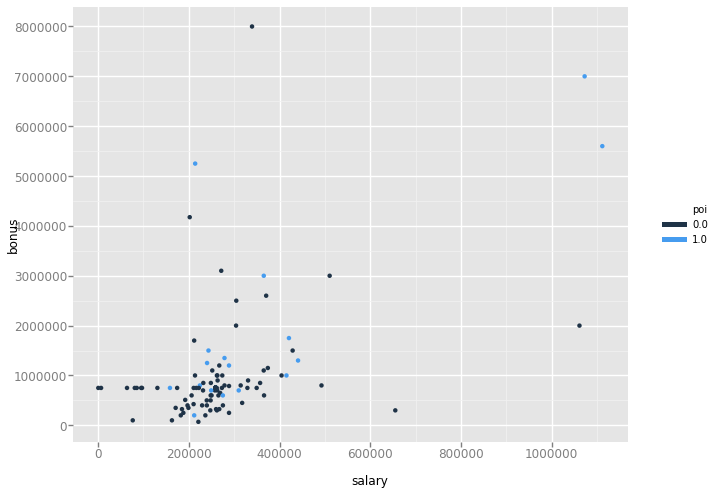

<ggplot: (16402885)>

In [17]:
ggplot(aes(x='salary',y='bonus',color='poi'),data=df_imputed)+geom_point()

### 2.2. Feature Selection

There are several email features:to messages, from messages,from poi to this person and from this person to poi. There variables only provide the number of emails of each category. However, I believe percentage of poi associated email will provide us with more information to identify other person of interest for further investigation.

Below, we calculate two fractions:

Fraction_from_poi: the percentage of email received from poi out of total messages received by this person

Fraction_to_poi: the precentage of email sent to poi out of total messages sent out by this person

In [7]:
df_imputed['fraction_from_poi']=df_imputed['from_poi_to_this_person']/df_imputed['from_messages']
df_imputed['fraction_to_poi']=df_imputed['from_this_person_to_poi']/df_imputed['to_messages']

In [8]:
df_imputed.shape

(144, 19)

In [9]:
features_list.append('fraction_from_poi')
features_list.append('fraction_to_poi')

In [16]:
df_imputed.head()

bonus  deferral_payments  deferred_income  exercised_stock_options  \
0   600000.0           221063.5        -151927.0                1297049.0   
1  1200000.0          1295738.0       -1386055.0                6680544.0   
2   350000.0           221063.5        -400729.0                4890344.0   
3   750000.0           221063.5        -151927.0                 651850.0   
4  1500000.0           221063.5       -3117011.0                5538001.0   

   expenses  from_messages  from_poi_to_this_person  from_this_person_to_poi  \
0   94299.0           29.0                     38.0                      1.0   
1   11200.0           41.0                     35.0                      8.0   
2   78552.0           41.0                     35.0                      8.0   
3   46547.5           12.0                     10.0                      0.0   
4   34039.0           32.0                     32.0                     21.0   

   long_term_incentive      other  poi  restricted_stock    salary  \
0             422158.0     1740.0  0.0          585062.0  365788.0   
1            1586055.0  2660303.0  0.0         3942714.0  267102.0   
2             422158.0    12961.0  0.0         1788391.0  170941.0   
3             422158.0    51984.5  0.0          386335.0  258741.0   
4            1617011.0    11350.0  1.0          853064.0  243293.0   

   shared_receipt_with_poi  to_messages  total_payments  total_stock_value  \
0                    702.0        807.0       1061827.0           585062.0   
1                    740.5       1211.0       5634343.0         10623258.0   
2                    740.5       1211.0        211725.0          6678735.0   
3                     58.0        764.0       1100246.5          1038185.0   
4                   1035.0       1045.0        288682.0          6391065.0   

   fraction_from_poi  fraction_to_poi  
0           1.310345         0.001239  
1           0.853659         0.006606  
2           0.853659         0.006606  
3           0.833333         0.000000  
4           1.000000         0.020096

Now the data are cleaned, we will use pipeline and GridSearchCV to find the best features for building classifiers.

In [10]:
labels = df_imputed['poi'].astype(int).as_matrix()
features = df_imputed.drop('poi',1).as_matrix()

In [20]:
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

pipe=Pipeline([("scaler",MinMaxScaler()),
               ("skb",SelectKBest()),
               ("clf",RandomForestClassifier(random_state=42))])

sss = StratifiedShuffleSplit(random_state = 0)
parameters={'skb__k':range(1,len(features_list)),
            "clf__n_estimators":[5,10,15,20,50,100],
            "clf__min_samples_split":[2,3,5],
            "clf__min_samples_leaf":[2,3,5]}
gs=GridSearchCV(pipe,parameters,cv=sss,scoring="f1")
gs.fit(features,labels)

GridSearchCV(cv=StratifiedShuffleSplit(n_splits=10, random_state=0, test_size=0.1,
            train_size=None),
       error_score='raise',
       estimator=Pipeline(steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('skb', SelectKBest(k=10, score_func=<function f_classif at 0x000000000CCD4C18>)), ('clf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=Non...stimators=10, n_jobs=1, oob_score=False, random_state=42,
            verbose=0, warm_start=False))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'clf__min_samples_leaf': [2, 3, 5], 'clf__min_samples_split': [2, 3, 5], 'clf__n_estimators': [5, 10, 15, 20, 50, 100], 'skb__k': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='f1', verbose=0)

In [21]:
K_best = gs.best_estimator_.named_steps['skb']

# Get SelectKBest scores, rounded to 2 decimal places, name them "feature_scores"
feature_scores = ['%.2f' % elem for elem in K_best.scores_ ]
# Get SelectKBest pvalues, rounded to 3 decimal places, name them "feature_scores_pvalues"
feature_scores_pvalues = ['%.3f' % elem for elem in  K_best.pvalues_ ]
# Get SelectKBest feature names, whose indices are stored in 'K_best.get_support',
# create a tuple of feature names, scores and pvalues, name it "features_selected_tuple"
features_selected_tuple=[(features_list[i+1], feature_scores[i], feature_scores_pvalues[i]) for i in K_best.get_support(indices=True)]

# Sort the tuple by score, in reverse order
features_selected_tuple = sorted(features_selected_tuple, key=lambda feature: float(feature[1]) , reverse=True)

print features_selected_tuple

[('exercised_stock_options', '27.42', '0.000'), ('to_messages', '23.68', '0.000'), ('bonus', '15.98', '0.000'), ('from_messages', '10.97', '0.001'), ('deferred_income', '10.37', '0.002')]


The above code prints out the features selected using GridSearchCV method. We can see that bonus, exercised stock options, to messages, from messages, deffered income are the best features to identify a person of interest.

In [13]:
features_kbest=K_best.fit_transform(features,labels)


### 2.3 Cross Validation

Next, we split the data into training and testing datasets and use the features we selected to train classifiers. Using training and testing datasets, or cross validation, is a method that is used to assess the performance of a classifier. We will use training set to fit the classifier and test the performance on testing dataset.

Since we only have 18 person of interest (POIs) out of 144 people in this dataset, the class is imbalanced. When one class is far less than the other, classifiers will tend to classify these cases POI=1 as POI=0. So a stratified shuffle split will work better in this case.

In [14]:
sss = StratifiedShuffleSplit(n_splits=3,test_size=0.3,random_state=42)
for train_index,test_index in sss.split(features_kbest,labels):
    features_train = []
    features_test  = []
    labels_train   = []
    labels_test    = []
    for ii in train_index:
        features_train.append( features_kbest[ii] )
        labels_train.append( labels[ii] )
    for jj in test_index:
        features_test.append( features_kbest[jj] )
        labels_test.append( labels[jj] )

## 3. Build Classifier

To evaluate the effectiveness of a classifier, accuracy score, precision rate and recall rate will be used. 
- Accuracy score: the proportion of the labels predicted correctly.
- Recall rate: True Positives/(True Positives+False Negatives)
- Precision rate: True Positives/(True Positives+ False Positives)





### 3.1 Gaussian Naive Bayes

In [15]:
from sklearn.naive_bayes import GaussianNB
g_clf = GaussianNB()
g_clf.fit(features_train,labels_train)
pred=g_clf.predict(features_test)

accuracy = accuracy_score(pred,labels_test)
recall=recall_score(labels_test,pred)
precision=precision_score(labels_test,pred)
print "The accuracy score of this classifier is: %s" % accuracy
print "The recall score of this classifier is: %s" % recall
print "The precision score of this classifier is: %s" % precision

The accuracy score of this classifier is: 0.840909090909
The recall score of this classifier is: 0.6
The precision score of this classifier is: 0.375


### 3.2 Random Forest

In [16]:
from sklearn.ensemble import RandomForestClassifier
r_clf=RandomForestClassifier()
r_clf.fit(features_train,labels_train)
pred=r_clf.predict(features_test)


accuracy = accuracy_score(pred,labels_test)
recall=recall_score(labels_test,pred)
precision=precision_score(labels_test,pred)
print "The accuracy score of this classifier is: %s" % accuracy
print "The recall score of this classifier is: %s" % recall
print "The precision score of this classifier is: %s" % precision

The accuracy score of this classifier is: 0.840909090909
The recall score of this classifier is: 0.2
The precision score of this classifier is: 0.25


### 3.3 Adaboost Classifier

In [17]:
from sklearn.ensemble import AdaBoostClassifier
a_clf=AdaBoostClassifier()
a_clf.fit(features_train,labels_train)
pred=a_clf.predict(features_test)

accuracy = accuracy_score(pred,labels_test)
recall=recall_score(labels_test,pred)
precision=precision_score(labels_test,pred)
print "The accuracy score of this classifier is: %s" % accuracy
print "The recall score of this classifier is: %s" % recall
print "The precision score of this classifier is: %s" % precision

The accuracy score of this classifier is: 0.772727272727
The recall score of this classifier is: 0.4
The precision score of this classifier is: 0.222222222222



### 3.4 Logistic Regression

In [18]:
from sklearn.linear_model import LogisticRegression
l_clf=LogisticRegression()
l_clf.fit(features_train,labels_train)
pred=l_clf.predict(features_test)

accuracy = accuracy_score(pred,labels_test)
recall=recall_score(labels_test,pred)
precision=precision_score(labels_test,pred)
print "The accuracy score of this classifier is: %s" % accuracy
print "The recall score of this classifier is: %s" % recall
print "The precision score of this classifier is: %s" % precision

The accuracy score of this classifier is: 0.886363636364
The recall score of this classifier is: 0.4
The precision score of this classifier is: 0.5


### 3.5 K Neighbors Classifier

In [19]:
from sklearn.neighbors import KNeighborsClassifier
k_clf=KNeighborsClassifier()
k_clf.fit(features_train,labels_train)
pred=k_clf.predict(features_test)

accuracy = accuracy_score(pred,labels_test)
recall=recall_score(labels_test,pred)
precision=precision_score(labels_test,pred)
print "The accuracy score of this classifier is: %s" % accuracy
print "The recall score of this classifier is: %s" % recall
print "The precision score of this classifier is: %s" % precision

The accuracy score of this classifier is: 0.863636363636
The recall score of this classifier is: 0.0
The precision score of this classifier is: 0.0


We tried 5 algorithms to classifier/predict person of interest. Amoung these, gaussian naive bayes classifier has the best performance in terms of precision and recall score. K neighbors classifier has the best performance in terms of accuracy score. Next we will tune algorithms and find the best parameter for prediction. Since Gaussian Naive Bayes do not have any parameters for tuning, we will work on K Neighbors Classifier, Random Forest Classifier and Logistic Regression.

## 4. Tuning Classifier

From previous section, we can see that random forest and adaboost have the best prediction accuracy. In this section, we will use GridSearchCV to tune the parameters for Adaboost classifier to maximize the accuracy of prediction.

Parameter tuning is essential in building machine learning algorithms. This means to adjust the input parameters of the algorithm to ensure the best performance of the algorithm on the dataset with selected features. If tuning is not done correctly, the algorithm may not be performing with its full potential. As a result, this could create more wrong predictions and lowered precision and recall rates. 


Using the tester.py code to check the performance of Gaussian Naive Bayes classifier:

### 4.1 Random Forest

In [77]:

parameters={
            "n_estimators":[5,10,15,20,50,100],
            "criterion":("gini","entropy"),
            "min_samples_split":[2,3,5],
            "min_samples_leaf":[2,3,5]}

r_clf=RandomForestClassifier()
gs=GridSearchCV(r_clf,parameters)
gs.fit(features_train,labels_train)
r_y_pred=gs.predict(features_test)


In [78]:
accuracy = accuracy_score(r_y_pred,labels_test)
recall=recall_score(labels_test,r_y_pred)
precision=precision_score(labels_test,r_y_pred)
print "The accuracy score of this classifier is: %s" % accuracy
print "The recall score of this classifier is: %s" % recall
print "The precision score of this classifier is: %s" % precision

The accuracy score of this classifier is: 0.840909090909
The recall score of this classifier is: 0.2
The precision score of this classifier is: 0.25


In [80]:
print gs.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=2,
            min_samples_split=3, min_weight_fraction_leaf=0.0,
            n_estimators=50, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)


### 4.2 K Neighbors Classifier

In [81]:
parameters={
            "n_neighbors":range(1,10),
            "algorithm":("ball_tree","kd_tree","brute"),
            'weights': ['uniform', 'distance'],
            'p': [1, 2], 'leaf_size': [1, 5, 9, 10, 20, 30, 40, 50, 60]}

k_clf=KNeighborsClassifier()
gs=GridSearchCV(k_clf,parameters)
gs.fit(features_train,labels_train)
k_y_pred=gs.predict(features_test)

In [82]:
accuracy = accuracy_score(k_y_pred,labels_test)
recall=recall_score(labels_test,k_y_pred)
precision=precision_score(labels_test,k_y_pred)
print "The accuracy score of this classifier is: %s" % accuracy
print "The recall score of this classifier is: %s" % recall
print "The precision score of this classifier is: %s" % precision

The accuracy score of this classifier is: 0.909090909091
The recall score of this classifier is: 0.2
The precision score of this classifier is: 1.0


### 4.3 Logistic Regression

In [75]:
parameters={"penalty":('l1','l2'),
            "C":(0.2,0.5,0.8,1,1.2,1.5,1.7,1.9,2),
            'max_iter':[100,200,500,1000]}

l_clf=LogisticRegression()
gs=GridSearchCV(l_clf,parameters)
gs.fit(features_train,labels_train)
l_y_pred=gs.predict(features_test)

In [76]:
accuracy = accuracy_score(l_y_pred,labels_test)
recall=recall_score(labels_test,l_y_pred)
precision=precision_score(labels_test,l_y_pred)
print "The accuracy score of this classifier is: %s" % accuracy
print "The recall score of this classifier is: %s" % recall
print "The precision score of this classifier is: %s" % precision

The accuracy score of this classifier is: 0.886363636364
The recall score of this classifier is: 0.6
The precision score of this classifier is: 0.5


Comparing the precision and recall rate of the models we tryied to tune, Naive Bayes is the only one with both metrics greater than 0.3. So I decided to use it as our final chosen algorithm.

## 5. Summary and Conclusion

In this project, we cleaned and studied the Enron dataset to build classifiers to identify if a person would be person of interest (POI) using financial features and email interactions between people. We first cleaned and impute the missing values and then calculated some ratios that would be useful in building classifiers. And next we built several classifiers using the training data and test the prediction power using test data. 

In the last section, we tuned the classifiers and tried to improve their predicting accuracy. I chose the Gaussian Naive Bayes classifier as the best method, based on precision and recall rates, for identifying POI employee in this study. The small sample size for model building is one of the factor that contribute to the low precision and recall rate. Since small sample size provides limited information when doing feature selection and modeling, the error rate in validation tend to be high.

## 6. Reference

sklearn help pages



http://stackoverflow.com/questions/22361781/how-does-sklearn-random-forest-index-feature-importances

https://stats.stackexchange.com/questions/58214/when-does-naive-bayes-perform-better-than-svm

http://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html

http://optunity.readthedocs.io/en/latest/notebooks/notebooks/sklearn-automated-classification.html
